Custom Model (Final)

Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay


import matplotlib.ticker as mtick
import seaborn as sns

import sklearn
import imblearn


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

sns.set()

In [2]:
# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="UGYDiy3HENiE7Y3dqoMAVIgG2",
    project_name="custom-models",
    workspace="ift6758a-a22-g3-projet",
)

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "learning_rate": 0.0001,
    "batch_size": 50,
    "num_epochs": 2,
    "criterion": "BinaryCrossEntropy",
    "optimizer": "Adam",
}
experiment.log_parameters(hyper_params)


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758a-a22-g3-projet/custom-models/ec654e52de6a4f31b3674d38155139f8



In [3]:
df = pd.read_csv('../ift6758/data/extracted/shot_goal_20151007_20210707.csv')

df_dropped = df[(df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (df['gameType'] == 'R') & (
            df['periodType'] != 'SHOOTOUT')]

df_filtered = df_dropped[['speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound', 'distanceFromPrev'
                          , 'secondsSincePrev', 'prevAngleWithGoal', 'prevY', 'prevX', 'prevEvent', 'prevSecondsSinceStart',
                          'angleWithGoal', 'distanceToGoal', 'x', 'y', 'emptyNet', 'strength', 'secondsSinceStart', 'shotType', 'isGoal']]

columns_count = len(df_filtered.columns) - 1

df_filtered['emptyNet'] = df_filtered['emptyNet'].fillna(0)
df_filtered['strength'] = df_filtered['strength'].fillna('Even')
df_filtered = df_filtered.dropna()

df_filtered.head(1)



C:\Users\Bei Ning\AppData\Local\Temp\ipykernel_36928\1794156082.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['emptyNet'] = df_filtered['emptyNet'].fillna(0)
C:\Users\Bei Ning\AppData\Local\Temp\ipykernel_36928\1794156082.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['strength'] = df_filtered['strength'].fillna('Even')


,speedOfChangeOfAngle,speed,changeOfAngleFromPrev,rebound,distanceFromPrev,secondsSincePrev,prevAngleWithGoal,prevY,prevX,prevEvent,prevSecondsSinceStart,angleWithGoal,distanceToGoal,x,y,emptyNet,strength,secondsSinceStart,shotType,isGoal
0,0.0,14.025066,0.0,False,154.275727,11.0,98.365886,-34.0,94.0,Hit,40.0,10.00798,34.525353,-55.0,6.0,0.0,Even,51,Wrist Shot,0.0


In [4]:
dummy_object = pd.get_dummies(df_filtered[['strength', 'shotType', 'prevEvent']])
df_filtered = df_filtered.merge(dummy_object, left_index=True, right_index=True)
df_filtered = df_filtered.drop(labels = ['strength', 'shotType', 'prevEvent'], axis = 1)

In [5]:
columns_count = len(df_filtered.columns)

Split Train & Validation Dataset

In [6]:
train, test = train_test_split(df_filtered, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(206814, 36)
(101864, 36)


In [7]:
x_train = train[['speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound',
       'distanceFromPrev', 'secondsSincePrev', 'prevAngleWithGoal', 'prevY',
       'prevX', 'prevSecondsSinceStart', 'angleWithGoal', 'distanceToGoal',
       'x', 'y', 'emptyNet', 'secondsSinceStart', 'strength_Even',
       'strength_Power Play', 'strength_Short Handed', 'shotType_Backhand',
       'shotType_Deflected', 'shotType_Slap Shot', 'shotType_Snap Shot',
       'shotType_Tip-In', 'shotType_Wrap-around', 'shotType_Wrist Shot',
       'prevEvent_Blocked Shot', 'prevEvent_Faceoff', 'prevEvent_Giveaway',
       'prevEvent_Goal', 'prevEvent_Hit', 'prevEvent_Missed Shot',
       'prevEvent_Penalty', 'prevEvent_Shot', 'prevEvent_Takeaway']]

y_train = train['isGoal']

x_train, y_train = RandomOverSampler().fit_resample(x_train, y_train)

x_test = test[['speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound',
       'distanceFromPrev', 'secondsSincePrev', 'prevAngleWithGoal', 'prevY',
       'prevX', 'prevSecondsSinceStart', 'angleWithGoal', 'distanceToGoal',
       'x', 'y', 'emptyNet', 'secondsSinceStart', 'strength_Even',
       'strength_Power Play', 'strength_Short Handed', 'shotType_Backhand',
       'shotType_Deflected', 'shotType_Slap Shot', 'shotType_Snap Shot',
       'shotType_Tip-In', 'shotType_Wrap-around', 'shotType_Wrist Shot',
       'prevEvent_Blocked Shot', 'prevEvent_Faceoff', 'prevEvent_Giveaway',
       'prevEvent_Goal', 'prevEvent_Hit', 'prevEvent_Missed Shot',
       'prevEvent_Penalty', 'prevEvent_Shot', 'prevEvent_Takeaway']]

y_test = test['isGoal']

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(375514, 35)
(375514,)
(101864, 35)
(101864,)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = F.sigmoid(x)
        
        return x
    
net = Net()

In [10]:
batch_size = hyper_params["batch_size"]
num_epochs = hyper_params["num_epochs"]
learning_rate = hyper_params["learning_rate"]
batch_no = len(x_train) // batch_size

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [11]:
x_train_t = torch.tensor(x_train.to_numpy(dtype=np.float32), dtype = torch.float32)
y_train_t = torch.tensor(y_train.values, dtype = torch.float32)

x_test_t = torch.tensor(x_test.to_numpy(dtype=np.float32), dtype = torch.float32)
y_test_t = torch.tensor(y_test.values, dtype = torch.float32)

In [ ]:
from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
    x_train_t, y_train_t = shuffle(x_train_t, y_train_t)
    # Mini batch learning
    loss_sum = 0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train_t[start:end]))
        y_var = Variable(torch.FloatTensor(y_train_t[start:end]))
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        ypred_var = net(x_var)
        loss =criterion(ypred_var, y_var[:,None])
        loss.backward()
        loss_sum = loss_sum + loss
        #print(loss)
        optimizer.step()
    print(loss_sum/batch_no)

In [13]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x_test_t), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
values = torch.round(result[:, 0])

num_right = np.sum(values.data.numpy().astype(int) == y_test)
print('Num Right', num_right)
print('Accuracy {:.2f}'.format(num_right / len(y_test_t)))

Num Right 83802
Accuracy 0.82


In [14]:
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import BinaryF1Score

target_m = torch.tensor(y_test.to_numpy()).to(torch.int)
pred_m = torch.tensor(values).to(torch.int)

confmat = ConfusionMatrix(num_classes=2)
confmat(target_m, pred_m)

C:\Users\Bei Ning\AppData\Local\Temp\ipykernel_36928\1599096580.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_m = torch.tensor(values).to(torch.int)


tensor([[78724,  4132],
        [13930,  5078]])

In [25]:
metric = BinaryF1Score()
print('F1 Pytorch')
print(metric(result[:, 0], target_m).item())
from sklearn.metrics import f1_score
f1 = f1_score(target_m.numpy(), values.numpy().astype(int), average='macro')
print('F1 Sklearn Macro')
print(f1)

F1 Pytorch
0.35991212725639343
F1 Sklearn Macro
0.6285002989111944


In [17]:
count = 0
for i in range(len(target_m)):
    if (target_m[i] != pred_m[i]):
        count = count + 1

print(count)
print(len(target_m))
print(1-count/len(target_m))

18062
101864
0.8226851488258855


In [18]:
fpr, tpr, threshold = metrics.roc_curve(y_test, result[:, 0].numpy())
roc_auc = metrics.auc(fpr, tpr)

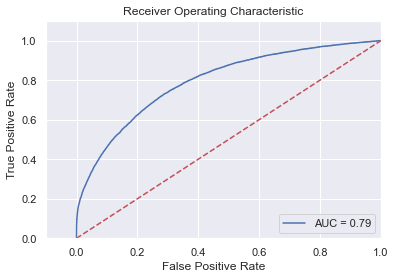

In [19]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
y_test_pred = values.numpy().astype(int)
score_prob = result[:, 0].numpy()

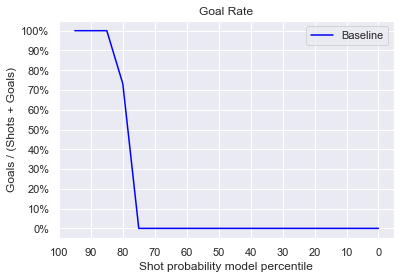

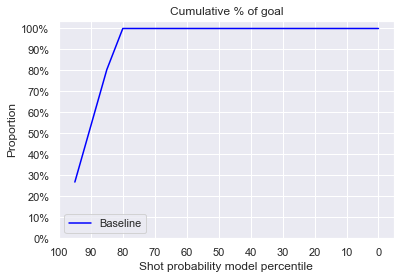

In [21]:
def prepare_goal_rate(y_array, score_prob):
    built_array = []
    index_array = list(range(0, 100, 5))
    total_goal = 0
    goal_array = []
    for i in range(0, 100, 5) :
        sub_y_array = y_array[np.logical_and(score_prob >= np.percentile(score_prob, i), score_prob < np.percentile(score_prob, i+5))]
        goals = np.count_nonzero(sub_y_array)
        shots = sub_y_array.size - goals
        sub_final = goals / (shots + goals)
        goal_array.append(goals)
        total_goal = total_goal + goals
        built_array.append(sub_final*100)
    return built_array, index_array, goal_array, total_goal

def create_goal_rate_plot(index_array, built_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, built_array, color="blue")
    plt.xticks(np.arange(0, 110, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['Baseline'])
    plt.title("Goal Rate")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Goals / (Shots + Goals)', fontsize=12)
    plt.show()

def compute_cumulative(goal_array, total_goal):
    cumulative_array = []
    last_elem = 0
    for i in np.flip(goal_array):
        if total_goal != 0:
            current = i / total_goal*100 + last_elem
        else:
            current = last_elem
        cumulative_array.append(current)
        
        last_elem = current
    return cumulative_array

def create_cumulative_plot(index_array, cumulative_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, cumulative_array, color="blue")
    plt.xticks(np.arange(0, 110, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['Baseline'])
    plt.title("Cumulative % of goal")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.show()

built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_test_pred, score_prob)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

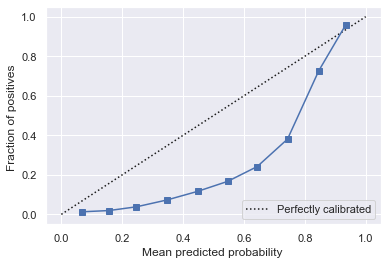

In [22]:
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

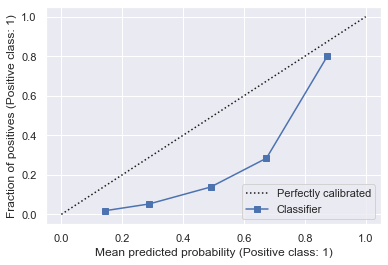

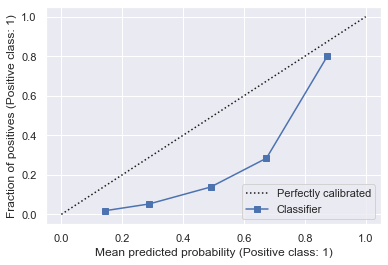

In [23]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob).plot()
plt.show()

In [24]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758a-a22-g3-projet/custom-models/ec654e52de6a4f31b3674d38155139f8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [1502] : (0.4200097620487213, 2.447200298309326)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 50
COMET INFO:     criterion     : BinaryCrossEntropy
COMET INFO:     learning_rate : 0.0001
COMET INFO:     num_epochs    : 2
COMET INFO:     optimizer     : Adam
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompre